## Step 1. Setup
It takes about one minute \\
(please note that GPU is required)


In [1]:
# @title setup

import os
diffusionclip_dir = os.path.join("/content", "EffDiff")

! git clone https://github.com/omertalmi5/eff-diff-edit $EffDiff_dir

os.chdir(f'./eff-diff-edit')
os.makedirs("precomputed", exist_ok=True)
os.makedirs("pretrained", exist_ok=True)
os.makedirs("runs", exist_ok=True)

! pip install ftfy regex tqdm
! pip install lmdb
! pip install pynvml
! pip install git+https://github.com/openai/CLIP.git

from utils.colab_utils import GoogleDrive_Dowonloader
from google.colab import auth
download_with_pydrive = True # param {type:"boolean"}
dl = GoogleDrive_Dowonloader(download_with_pydrive)


from effdiff import EffDiff
from main import dict2namespace
import argparse
import yaml
from PIL import Image
import warnings
from skimage.io import imread_collection
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

device = 'cuda'

%load_ext autoreload
%autoreload 2



import os

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


download_with_pydrive = True

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

downloader.download_file('1KW7bjndL3QG3sxBbZxreGHigcCCpsDgn',
                         'pretrained/model_ir_se50.pth')

Cloning into 'eff-diff-edit'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 327 (delta 29), reused 1 (delta 1), pack-reused 271 (from 1)
Receiving objects: 100% (327/327), 19.32 MiB | 12.44 MiB/s, done.
Resolving deltas: 100% (133/133), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4vklcgu_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4vklcgu_
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=12

In [2]:
!git pull


Already up to date.


## Step 2. Editing part

**Below we list few tips for you to make your play easier**

In addition, you can find extended description of the options in *'EffDiff/docs/clip-finetune-help'*

---

**1.** Put your image into the folder *'EffDiff/own_images/your_name'*. \\
Then fill corresponding option below (***--own_image***). \\
In the first run you can try our image:

```
--own_image man.png (or girl.png)
```
**2.** Choose the editing attribute
```
--edit_attr makeup
```
full list of available transformations: \\
*   *tanned* (face → tanned face)
*   *pale* (face → pale face)
*   *makeup* (person → person with makeup)
*   *old* (person → old person)
*   *young* (person → young person)
*   *angry* (face → angry face)
*   *surprised* (face → surprised face)
*   *smiling* (face → smiling face)
*   *red_hair* (person → person with red hair)
*   *curly_hair* (person → person with curly hair)
*   *nicolas* (person → Nicolas Cage)
*   *zuckerberg* (person → Mark Zuckerberg)
*   *benedict* (person → Benedict Cumberbatch)
*   *pitt* (person → Brad Pitt)
*   *botero* (person → Painting in Fernando Botero style)
*   *gogh* (person → painting by Gogh)
*   *frida* (person → self-portrait by Frida Kahlo)
*   *modigliani* (person → Painting in Modigliani style)
*   *jolie* (person → Angelina Jolie)
*   *sketch* (photo → sketch)
*   *watercolor* (photo → Watercolor Art with Thick Brushstrokes)
*   *elf* (Human → Tolkien elf)
*   *super_saiyan* (Human → Super saiyan)
*   *pixar* (Human → 3D render in the style of Pixar)
*   *neanderthal* (Human → Neanderthal)
*   *zombie* (Human → zombie)
*   *jocker* (Human → The Jocker)
*   *superman* (Human → Superman)
*   *carrey* (Human → Jim Carrey)

To add your own transformation you can change the *EffDiff/utils/text_dic.py* file.

**3.** To improve your editing you can change the following options:
```
--align_face (1 or 0) (face alignment)
*   1 usually helps for external images, but sometimes it does not. Try both.
```
```
--n_iter (3-20) (number of training iterations)
*   usually, few iterations are required (like 5-7). But try high values for strong transformations, like zombie.
```
```
--t_0 (250-600) (degree of noise to encode an image)
*   small values for shallow transformations (like makeup, angry)
*   high values for strong ones (like zombie)
```
```
--fast_noising_train (1 or 0) (stochastic/deterministic encoding)
--fast_noising_test (1 or 0)
*   1 - stochastic encoding, 0 - deterministic. Both can provide good results in some cases.
    Deterministic encoding sometimes provides artefacts for low values of t_0,
    but stochastic can lose a person's identity at high ones.
```
```
--lr_clip_finetune (from 1e-6 to 2e-5)
*   higher values can provide stronger transformation.
```
```
--l1_loss_w (regularization coefficient)
*   try to increase if you meet artifacts (note: change manually in the code)
```
```
--n_train_step (from 1 to 6) (number of DDIM steps to decode a transformed image)
*   higher values can make your transformation stronger,
    but for deterministic encoding
```

P.S. Firstly, it downloads some stuff (external models). After the first run the code will require about 20 secs


Original diffusion Model loaded.
Setting optimizer with lr=6e-06
Loading losses
Uniform skip type
____________________________________________________
['joker.jpg']
runs/single_editing
   ['Hillary Clinton']
-> ['joker.jpg']
Prepare identity latent
precomputed/CelebA_HQ_train_t310_nim1_ninv40_pairs.pth
Aligned image has shape: (256, 256)
precomputed/CelebA_HQ_test_t310_nim1_ninv40_pairs.pth
Aligned image has shape: (256, 256)
Start finetuning
Sampling type: DDIM with eta 0.0
CHANGE Hillary Clinton TO joker.jpg
Aligned image has shape: (256, 256)
CLIP 0-0: loss_l1: 0.064, loss_clip: 0.680
Training for 1 image(s) takes 1.5840s
Aligned image has shape: (256, 256)
CLIP 0-1: loss_l1: 0.065, loss_clip: 0.569
Training for 1 image(s) takes 1.5342s
Aligned image has shape: (256, 256)
CLIP 0-2: loss_l1: 0.066, loss_clip: 0.530
Training for 1 image(s) takes 1.5170s
Aligned image has shape: (256, 256)
CLIP 0-3: loss_l1: 0.067, loss_clip: 0.494
Training for 1 image(s) takes 2.2406s
Aligned image ha

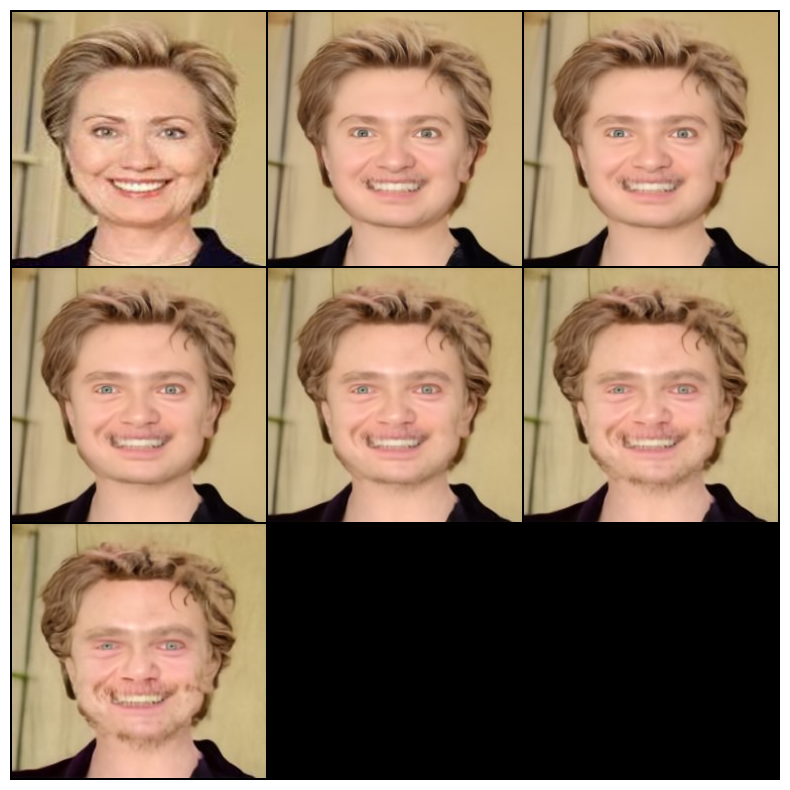

In [4]:
#@title Single image editing

own_image = 'hilery_image.jpg'  #@param {type:"string"}
degree_of_noise = 310 #@param {type:"slider", min:200, max:700, step:10}
config = 'celeba.yml'
edit_attr = 'elf'  #@param ['tanned', 'pale','makeup', 'old', 'young', 'angry', 'surprised', 'smiling', 'red_hair', 'curly_hair', 'nicolas', 'zuckerberg', 'benedict', 'pitt', 'botero', 'gogh', 'frida', 'modigliani', 'jolie', 'sketch', 'watercolor', 'elf', 'pixar', 'neanderthal', 'zombie', 'jocker', 'superman', 'carrey']
align_face = "1" #@param [0, 1]
stoshastic_encoding = "1" #@param [0, 1]
training_iterations = 6 #@param {type:"slider", min:1, max:20, step:1}
generation_steps = 4 #@param {type:"slider", min:1, max:6, step:1}
regularization = 2 #@param {type:"slider", min:0, max:10, step:1}

args_dic = {
    'config': 'celeba.yml',
    't_0': degree_of_noise,
    'own_test': own_image,
    'fast_noising_train': int(stoshastic_encoding),
    'fast_noising_test': int(stoshastic_encoding),
    'n_train_step': int(generation_steps),
    'n_test_step': int(generation_steps),
    'own_training': 1,
    'single_image': 1,
    'n_train_img': 1,
    'n_precomp_img': 1,
    'exp': 'runs/single_editing',
    'n_test_img': 1,
    'lr_clip_finetune': 6e-6,
    'model_path': None,
    'l1_loss_w': float(regularization),
    'n_inv_step': int(40),
    'eta': 0.0,
    'sch_gamma': 1.3,
    'number_of_image': 0,
    'sample_type': 'ddim',
    'clip_model_name': 'ViT-B/16',
    'image_folder': 'runs/single_editing/image_samples',
    'n_iter': training_iterations,
    'align_face': int(align_face),
    'edit_attr': edit_attr,
    'clip_loss_w': 3.0,
    'do_test': 1,
    'id_loss_w': 0.0,
    }

!rm -r precomputed
!rm -r runs
os.makedirs('runs/single_editing/image_samples')
os.makedirs('precomputed', exist_ok=True)

args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = EffDiff(args, config)
runner.clip_finetune()

col_dir = 'runs/single_editing/image_samples/*.png'

col = np.array(imread_collection(col_dir))
batch_tensor = torch.tensor(col).permute(0, 3, 1, 2)
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=3)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))